In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad
from sklearn.cluster import KMeans
from ffjord.lib.toy_data import inf_train_gen

import torch
from torch import nn
from torch.distributions import transform_to, biject_to

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroParam
from pyro.distributions import constraints
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
pyro.enable_validation(True)

# Gaussian Mixture model

In [2]:
class GaussianMixtureModel(PyroModule):
    """Gaussian Mixture Model following the CP formulation"""
    def __init__(self, K):
        super().__init__()
        self.K = K
        self.M = None
        self.locs = None
        self.scales = None
        self.initialized = False
        self.weights = PyroParam(
            torch.ones(K) / K,
            constraint=dist.constraints.simplex)
        self.train_losses = list()
        self.eval()
    
        
    @config_enumerate
    def forward(self, data=None):
        N, M = data.shape if data is not None else (1000, 2)
        
        if self.initialized is False and data is not None:
            self.init_from_data(data)
        elif self.initialized is False:
            self.random_init(M)
        
        if M != self.M:
            raise ValueError('Incorrect number of data columns.')
        
        # Empty tensor for data samples
        x_sample = torch.empty(N, M)
        
        with pyro.plate('data', N):
            # Sample cluster/component
            k = pyro.sample('k', dist.Categorical(self.weights))
            
            for m in range(self.M):
                # Observations of x_m
                obs = data[:,m] if data is not None else None
                
                # Sample x_m
                x_sample[:,m] = pyro.sample(
                    f'x_{m}',
                    dist.Normal(loc=self.locs[k, m],
                                scale=self.scales[k, m]),
                    obs=obs)
                
            return x_sample
    
    
    def init_from_data(self, data, k_means=False):
        N, M = data.shape
        self.M = M
        
        self.locs = PyroParam(
            data[torch.multinomial(torch.ones(N) / N, self.K),],
            constraint=constraints.real)
        
        self.scales = PyroParam(
            data.std(dim=0).repeat(self.K).reshape(self.K, self.M),
            constraint=constraints.positive)
        
        if k_means:
            k_means_model = KMeans(self.K)
            k_means_model.fit(data.numpy())
            locs = k_means_model.cluster_centers_
            
            self.locs = PyroParam(
                torch.tensor(locs),
                constraint=constraints.real)
        
        self.initialized = True
    
    
    def random_init(self, M):
        self.M = M
        
        self.locs = PyroParam(
            torch.rand(self.K, self.M),
            constraint=constraints.real)
        
        self.scales = PyroParam(
            torch.rand(self.K, self.M),
            constraint=constraints.positive)
        
        self.initialized = True
        
    
    def guide(self, data):
        pass
    
    
    def fit_model(self, data, lr=3e-4, n_steps=10000):
        self.train()
        
        N = len(data)
        adam = pyro.optim.Adam({"lr": lr})
        svi = SVI(self, self.guide, adam, loss=TraceEnum_ELBO())
        
        for step in range(n_steps):
            loss = svi.step(data)
            self.train_losses.append(loss)
            
            if step % 1000 == 0:
                print('[iter {}]  loss: {:.4f}'.format(step, loss))
        
        self.eval()
    
    
    def density(self, data):
        with torch.no_grad():
            N, M = data.shape
            
            if M != self.M:
                raise ValueError('Incorrect number of data columns.')
            
            log_probs = dist.Normal(
                loc=self.locs,
                scale=self.scales).log_prob(data.unsqueeze(1))
            
            density = (
                torch.exp(log_probs.sum(dim=2))*self.weights).sum(dim=1)
            
            return density
        
    
    def log_likelihood(self, data):
        with torch.no_grad():
            llh = torch.log(self.density(data)).sum()
            return llh
    
    
    def eval_density_grid(self, n_points=100):
        if self.M != 2:
            raise ValueError('Can only evaluate density grid for 2-dimensional data.')
        x_range = np.linspace(-5, 5, n_points)
        X1, X2 = np.meshgrid(x_range, x_range)
        XX = np.column_stack((X1.ravel(), X2.ravel()))
        densities = self.density(torch.tensor(XX)).numpy()
        
        return x_range, densities.reshape((n_points, n_points))
        


In [3]:
def plot_train_loss(model):
    fig = plt.figure(figsize=(8,6))
    plt.plot(model.train_losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.show();


def plot_density(model, data):
    x_range, density_eval = model.eval_density_grid(n_points=500)
    fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2,
                                    figsize=(20, 10))
    # Plot of data and contour lines of density
    ax1.plot(data[:,0], data[:,1], 'b.', markersize=1)
    ax1.contour(x_range, x_range, density_eval, colors='red')
    ax1.set_xlabel('x_1')
    ax1.set_ylabel('x_2')
    ax1.set_title('Data and contour lines of density')

    # Color map of density
    cm = ax2.pcolormesh(x_range, x_range, density_eval, cmap=plt.cm.RdBu_r, shading='auto')
    cbar = fig.colorbar(cm)
    ax2.set_xlabel('x_1')
    ax2.set_ylabel('x_2')
    ax2.set_title('Heat map of density')
    plt.show();


## 8 Gaussians data

In [4]:
# Generate synthetic data
data_1 = torch.tensor(inf_train_gen('8gaussians', batch_size=5000),
                      dtype=torch.float)

In [5]:
# Train model
pyro.clear_param_store()
model = GaussianMixtureModel(K=8)
model.init_from_data(data_1, k_means=True)
model.fit_model(data_1, n_steps=8000)

[iter 0]  loss: 22131.4395
[iter 1000]  loss: 20713.0078
[iter 2000]  loss: 19476.5059
[iter 3000]  loss: 17970.6191
[iter 4000]  loss: 15794.8037
[iter 5000]  loss: 14536.5781
[iter 6000]  loss: 14170.9512
[iter 7000]  loss: 14133.7021


In [6]:
# Log likelihood of data
print('Log likelihood of data:', model.log_likelihood(data_1).item())

Log likelihood of data: -14133.0439453125


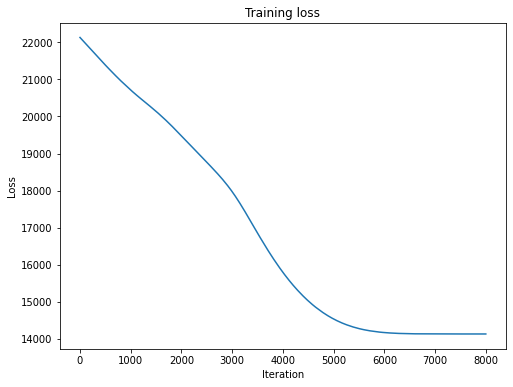

In [7]:
# Plot training loss
plot_train_loss(model)

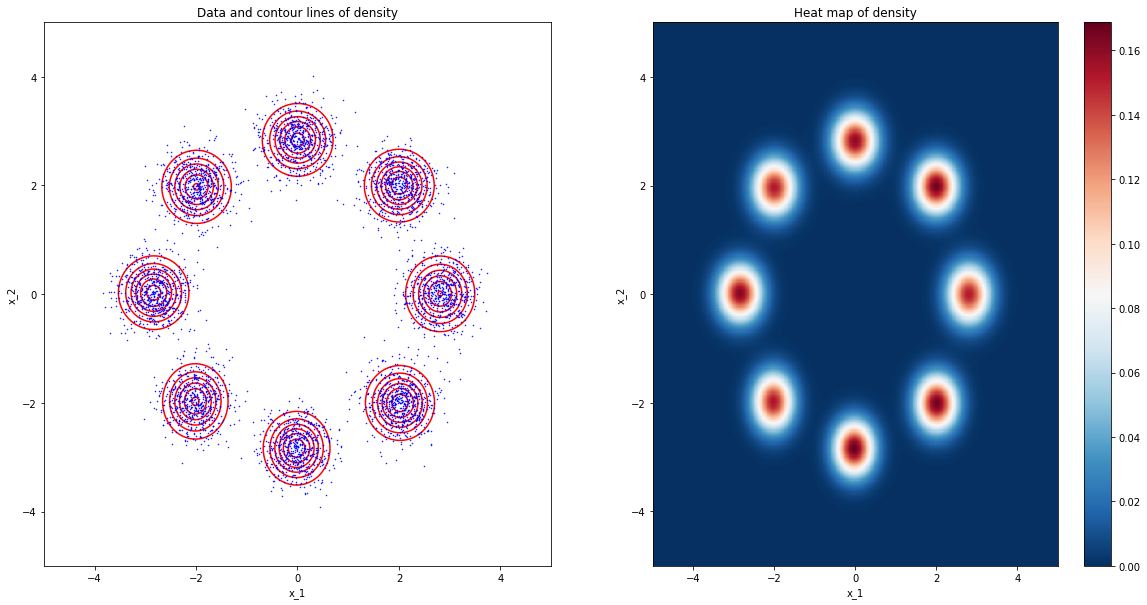

In [8]:
# Plot density
plot_density(model, data_1)

## Checkerboard data 

In [2]:
# Generate synthetic data
data_2 = torch.tensor(inf_train_gen('checkerboard', batch_size=5000),
                      dtype=torch.float)

In [10]:
# Train model
pyro.clear_param_store()
model = GaussianMixtureModel(K=8)
model.init_from_data(data_2, k_means=True)
model.fit_model(data_2, n_steps=8000)

[iter 0]  loss: 23402.3008
[iter 1000]  loss: 22320.3770
[iter 2000]  loss: 21531.2559
[iter 3000]  loss: 20499.6777
[iter 4000]  loss: 19309.3164
[iter 5000]  loss: 19079.1992
[iter 6000]  loss: 19071.4434
[iter 7000]  loss: 19071.4570


In [11]:
# Log likelihood of data
print('Log likelihood of data:', model.log_likelihood(data_2).item())

Log likelihood of data: -19071.421875


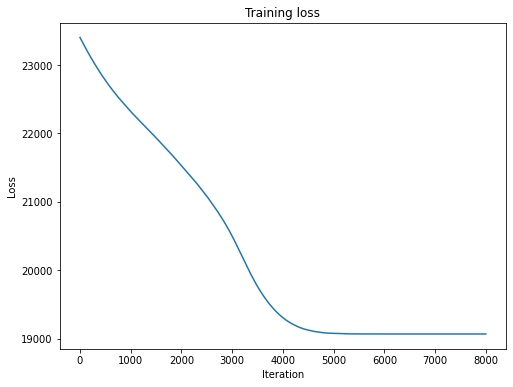

In [12]:
# Plot training loss
plot_train_loss(model)

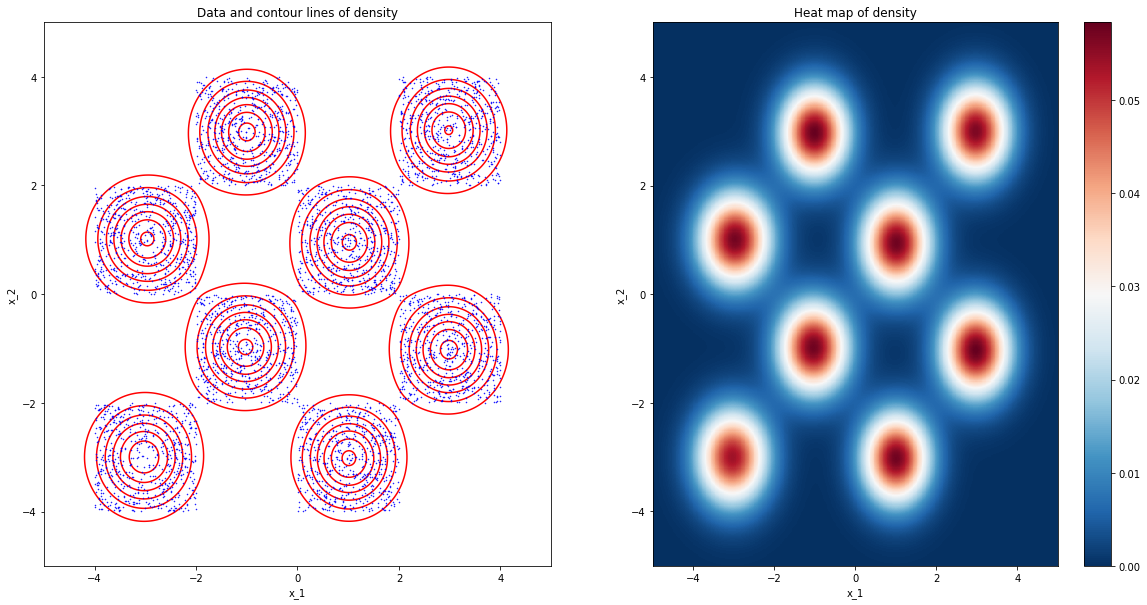

In [13]:
# Plot density
plot_density(model, data_2)

## 2 Spirals data

In [14]:
# Generate synthetic data
data_3 = torch.tensor(inf_train_gen('2spirals', batch_size=5000),
                      dtype=torch.float)

In [15]:
# Train model
pyro.clear_param_store()
model = GaussianMixtureModel(K=8)
model.init_from_data(data_3, k_means=True)
model.fit_model(data_3, n_steps=8000)

[iter 0]  loss: 19643.2383
[iter 1000]  loss: 18543.9336
[iter 2000]  loss: 18126.3379
[iter 3000]  loss: 17912.7461
[iter 4000]  loss: 17734.0938
[iter 5000]  loss: 17335.1406
[iter 6000]  loss: 17127.9043
[iter 7000]  loss: 17091.8633


In [16]:
# Log likelihood of data
print('Log likelihood of data:', model.log_likelihood(data_3).item())

Log likelihood of data: -17081.72265625


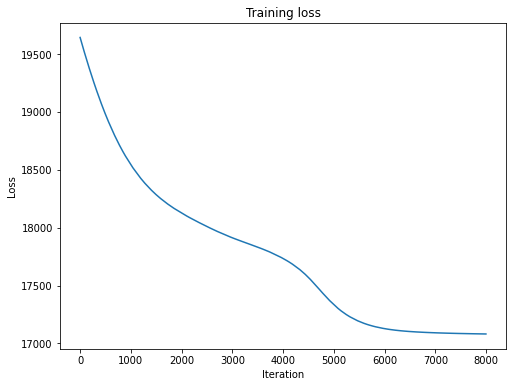

In [17]:
# Plot training loss
plot_train_loss(model)

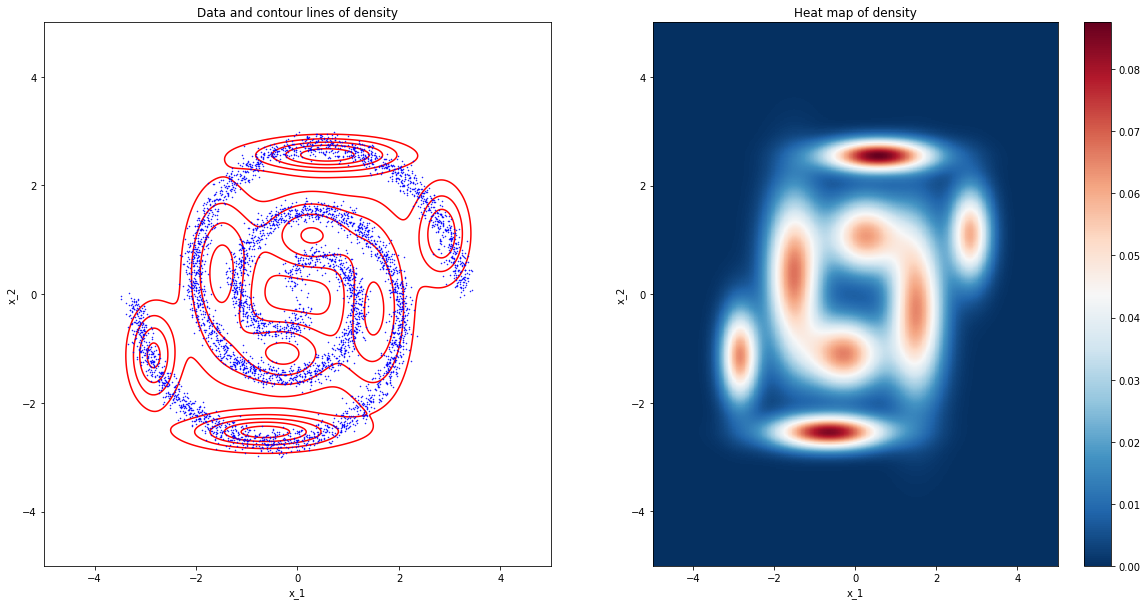

In [18]:
# Plot density
plot_density(model, data_3)

# CP Model

In [21]:
class CPModel(PyroModule):
    """CP model where the distribution on each 
       variable can be specified"""
    def __init__(self, K, distributions):
        super().__init__()
        self.K = K
        self.M = len(distributions)
        self.train_losses = list()
        
        self.weights = PyroParam(
            torch.ones(self.K) / self.K,
            constraint=constraints.simplex)
        
        self.components = nn.ModuleList()
        
        for m, d in enumerate(distributions):
            # Create pyro module for attribute m (i.e. x_m)
            component = PyroModule(name=str(m))
            
            # Distribution of x_m
            component.dist = d
            
            # List for parameter names of distribution
            component.params = list()
            
            # Parameters and constraints of distribution
            for param, constr in d.arg_constraints.items():
                # Initialize parameter and set as an attribute of the component
                # Example: 
                # component.loc = PyroParam(init_tensor, constraint=constraints.real)
                init_tensor = transform_to(constr)(
                    torch.empty(self.K).uniform_(-5,5))
                setattr(component, param, PyroParam(init_tensor, constraint=constr))
                
                # Add parameter name to list
                component.params.append(param)
            
            # Add component to module list 
            self.components.append(component)
        
        self.eval()
        
    
    @config_enumerate
    def forward(self, data=None):
        N, M = data.shape if data is not None else (1000, self.M)
        
        if M != self.M:
            raise ValueError('Incorrect number of data columns.')
        
        # Empty tensor for samples
        x_sample = torch.empty(N, M)
        
        with pyro.plate('data', N):
            # Draw cluster/component
            k = pyro.sample('k', dist.Categorical(self.weights))
            
            for m in range(M):
                # Observations of x_m
                obs = data[:,m] if data is not None else None
                
                # Parameters for distribution of x_m
                params = {param: getattr(self.components[m], param)[k]
                          for param in self.components[m].params}
                
                # Draw samples of x_m
                x_sample[:,m] = pyro.sample(
                    f'x_{m}',
                    self.components[m].dist(**params),
                    obs=obs)
            
            return x_sample
    
    
    def init_from_data(self, data, n_tries=100):
        inits = list()
        
        for seed in range(n_tries):
            pyro.set_rng_seed(seed)
            pyro.clear_param_store()
            
            # Set new initial parameters
            for c in self.components:
                for param, constr in c.dist.arg_constraints.items():
                    init_tensor = transform_to(constr)(
                        torch.empty(self.K).uniform_(-5,5))
                    setattr(c, param, PyroParam(init_tensor,
                                                constraint=constr))
            
            # Get initial loss
            svi = SVI(self, self.guide,
                      pyro.optim.Adam({}),
                      loss=TraceEnum_ELBO())
            
            # Save loss and seed
            inits.append((svi.loss(model, self.guide, data),
                          seed))
        
        # Best initialization
        loss, seed = min(inits)
        
        # Initialize with best seed
        pyro.set_rng_seed(seed)
        pyro.clear_param_store()
        for c in self.components:
            for param, constr in c.dist.arg_constraints.items():
                init_tensor = transform_to(constr)(
                    torch.empty(self.K).uniform_(-5,5))
                setattr(c, param, PyroParam(init_tensor,
                                            constraint=constr))
    
    
    def guide(self, data):
        pass
    
    
    def fit_model(self, data, lr=3e-4, n_steps=10000):
        self.train()
        
        adam = pyro.optim.Adam({"lr": lr})
        svi = SVI(self, self.guide, adam, loss=TraceEnum_ELBO())
        
        for step in range(n_steps):
            loss = svi.step(data)
            self.train_losses.append(loss)
            
            if step % 1000 == 0:
                print('[iter {}]  loss: {:.4f}'.format(step, loss))
        
        self.eval()
    
    
    def density(self, data):
         with torch.no_grad():
            N, M = data.shape
            
            if M != self.M:
                raise ValueError('Incorrect number of data columns.')
            
            log_probs = torch.empty(N, self.K, M)
            
            for m in range(M):
                params = {param: getattr(self.components[m], param)
                          for param in self.components[m].params}
                
                log_probs[:,:,m] = self.components[m].dist(
                    **params).log_prob(data[:,m].unsqueeze(1))
            
            density = (
                torch.exp(log_probs.sum(dim=2))*self.weights).sum(dim=1)
            
            return density
    
    
    def log_likelihood(self, data):
        with torch.no_grad():
            llh = torch.log(self.density(data)).sum()
            return llh
    
    
    def eval_density_grid(self, n_points=100):
        if self.M != 2:
            raise ValueError('Can only evaluate density grid for 2-dimensional data.')
        x_range = np.linspace(-5, 5, n_points)
        X1, X2 = np.meshgrid(x_range, x_range)
        XX = np.column_stack((X1.ravel(), X2.ravel()))
        densities = self.density(torch.tensor(XX)).numpy()
        
        return x_range, densities.reshape((n_points, n_points))
    
    
    def unit_test(self, int_limits):
        """Integrates probablity density"""
        return nquad(
            lambda *args: self.density(torch.tensor([args])).item(),
            int_limits)
    

## 8 Gaussians data

In [22]:
# Train model
pyro.clear_param_store()
model = CPModel(K=8, distributions=[dist.Normal, dist.Normal])
model.init_from_data(data_1, n_tries=1000)
model.fit_model(data_1, n_steps=15000)

[iter 0]  loss: 26607.9355
[iter 1000]  loss: 23321.5059
[iter 2000]  loss: 21702.2695
[iter 3000]  loss: 20566.0527
[iter 4000]  loss: 19738.8652
[iter 5000]  loss: 19169.6035
[iter 6000]  loss: 18664.8047
[iter 7000]  loss: 18190.8594
[iter 8000]  loss: 17748.5801
[iter 9000]  loss: 17204.8438
[iter 10000]  loss: 16626.6836
[iter 11000]  loss: 16080.4541
[iter 12000]  loss: 15799.7832
[iter 13000]  loss: 15695.3252
[iter 14000]  loss: 15664.2549


In [23]:
# Log likelihood of data
print('Log likelihood of data:', model.log_likelihood(data_1).item())

Log likelihood of data: -15495.5859375


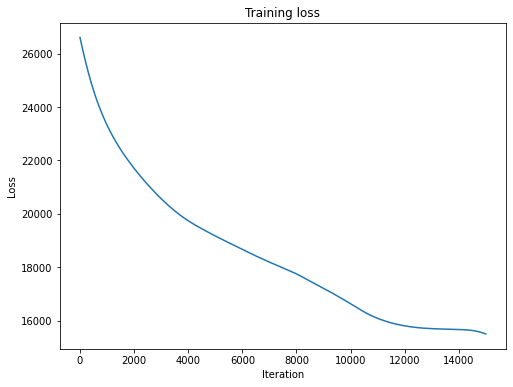

In [24]:
# Plot training loss
plot_train_loss(model)

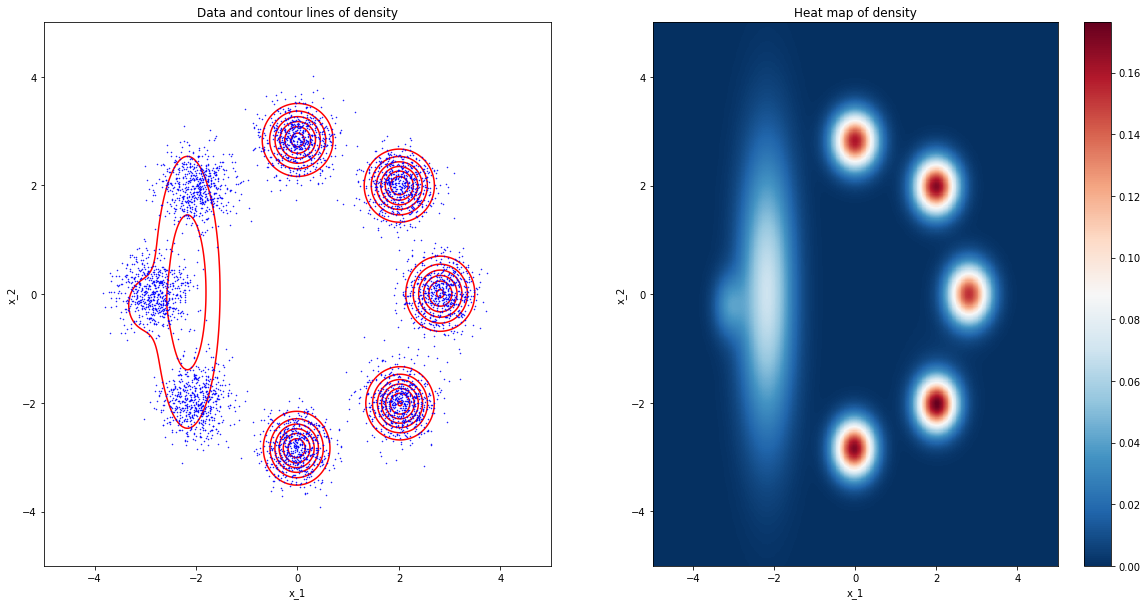

In [25]:
# Plot density
plot_density(model, data_1)

In [26]:
# Unit Test 
model.unit_test([(-4, 4), (-4, 4)])

(0.992265272579032, 1.4851904732192725e-08)

## Checkerboard data

In [27]:
# Train model
pyro.clear_param_store()
model = CPModel(K=8, distributions=[dist.Normal, dist.Normal])
model.init_from_data(data_2, n_tries=1000)
model.fit_model(data_2, n_steps=15000)

[iter 0]  loss: 27931.8906
[iter 1000]  loss: 25437.1914
[iter 2000]  loss: 23917.3594
[iter 3000]  loss: 22985.9531
[iter 4000]  loss: 22360.7305
[iter 5000]  loss: 21969.1934
[iter 6000]  loss: 21741.7305
[iter 7000]  loss: 21520.0898
[iter 8000]  loss: 21356.5430
[iter 9000]  loss: 21272.6152
[iter 10000]  loss: 21234.6621
[iter 11000]  loss: 21146.8418
[iter 12000]  loss: 20943.9707
[iter 13000]  loss: 20816.4961
[iter 14000]  loss: 20767.5801


In [28]:
# Log likelihood of data
print('Log likelihood of data:', model.log_likelihood(data_2).item())

Log likelihood of data: -20751.51171875


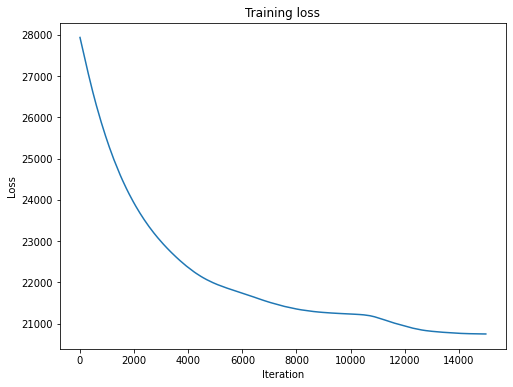

In [29]:
# Plot training loss
plot_train_loss(model)

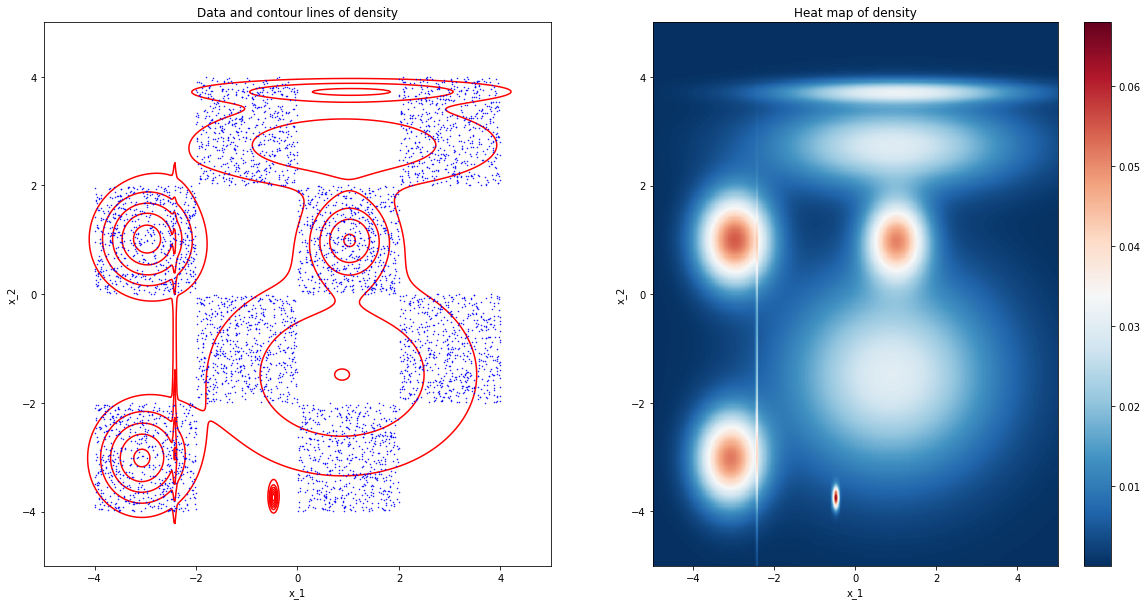

In [30]:
# Plot density
plot_density(model, data_2)

In [31]:
# Unit Test (Increase limits if result is far from 1)
model.unit_test([(-4, 4), (-4, 4)])

/Users/jonas/.virtualenvs/tfde/lib/python3.7/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)


(0.9304801420455501, 2.624248715077382e-05)

## 2 Spirals data

In [32]:
# Train model
pyro.clear_param_store()
model = CPModel(K=8, distributions=[dist.Normal, dist.Normal])
model.init_from_data(data_3, n_tries=1000)
model.fit_model(data_3, n_steps=15000)

[iter 0]  loss: 25792.6016
[iter 1000]  loss: 22394.5117
[iter 2000]  loss: 20457.0547
[iter 3000]  loss: 19445.0938
[iter 4000]  loss: 18919.4023
[iter 5000]  loss: 18613.2090
[iter 6000]  loss: 18435.9980
[iter 7000]  loss: 18320.0137
[iter 8000]  loss: 18204.9355
[iter 9000]  loss: 18014.2031
[iter 10000]  loss: 17916.0977
[iter 11000]  loss: 17844.9805
[iter 12000]  loss: 17797.7871
[iter 13000]  loss: 17759.0879
[iter 14000]  loss: 17742.6309


In [33]:
# Log likelihood of data
print('Log likelihood of data:', model.log_likelihood(data_3).item())

Log likelihood of data: -17732.626953125


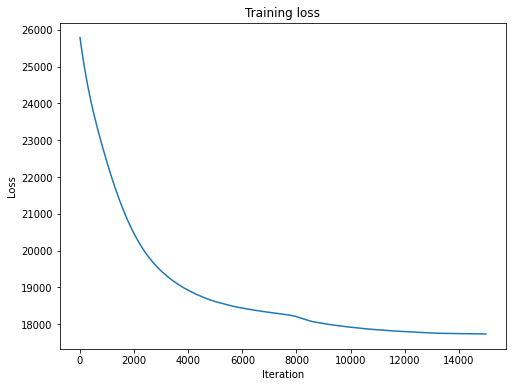

In [34]:
# Plot training loss
plot_train_loss(model)

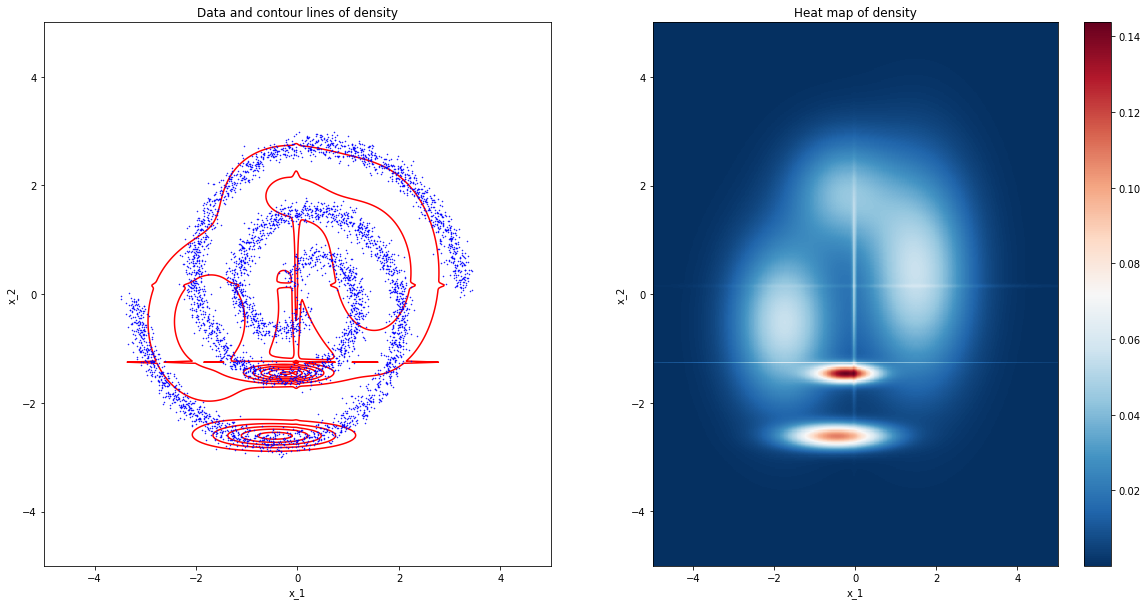

In [35]:
# Plot density
plot_density(model, data_3)

In [36]:
# Unit Test (Increase limits if result is far from 1)
model.unit_test([(-4, 4), (-4, 4)])

(0.9953041166502884, 1.4864499888887522e-08)

# Tensor Train

In [163]:
class TensorTrain(PyroModule):
    """Tensor Train model"""
    def __init__(self, Ks):
        super().__init__()
        self.Ks = Ks
        self.M = len(Ks) - 1
        self.train_losses = list()
        
        # Weights for latent variable k_0
        self.k0_weights = PyroParam(
            torch.ones(self.Ks[0]) / self.Ks[0],
            constraint=dist.constraints.simplex)
        
        # Parameters indexed by latent variable number
        # I.e. by 1, 2,..., M
        self.params = nn.ModuleDict()
        
        # Intialize weights, locs and scales
        self.init_params()

        
    def init_params(self, loc_min=None, loc_max=None, scale_max=None):
        
        if loc_min is None:
            loc_min = [-1 for m in range(self.M)]
        if loc_max is None:
            loc_max = [1 for m in range(self.M)]
        if scale_max is None:
            scale_max = [1 for m in range(self.M)]
        
        for m in range(1, self.M + 1):
            # PyroModule for storing weights, locs
            # and scales for x_m
            module = PyroModule(name=f'x_{m}')
            param_shape = (self.Ks[m-1], self.Ks[m])
            
            # Weight matrix W^m ("Transition probabilities")
            # I.e. probability of k_m = a given k_{m-1} = b
            module.weights = PyroParam(
                torch.ones(param_shape) / self.Ks[m],
                constraint=constraints.simplex)
            
            # Locs for x_m
            module.locs = PyroParam(
                dist.Uniform(loc_min[m-1], loc_max[m-1]).sample(param_shape),
                constraint=constraints.real)
            
            # Scales for x_m
            module.scales = PyroParam(
                dist.Uniform(0, scale_max[m-1]).sample(param_shape),
                constraint=constraints.positive)
            
            self.params[str(m)] = module
        
    
    @config_enumerate
    def forward(self, data=None):
        N, M = data.shape if data is not None else (1000, 2)
        
        if M != self.M:
            raise ValueError('Incorrect number of data columns.')
        
        # Empty tensor for data samples
        x_sample = torch.empty(N, M)
        
        with pyro.plate('data', N):
            # Sample k0
            k_m_prev = pyro.sample(
                'k_0', 
                dist.Categorical(self.k0_weights))
            
            
            for m, params in enumerate(self.params.values()):
                # Sample k_m
                k_m = pyro.sample(
                    f'k_{m+1}',
                    dist.Categorical(params.weights[k_m_prev]))
                
                # Observations of x_m
                obs = data[:,m] if data is not None else None
                
                # Sample x_m
                x_sample[:,m] = pyro.sample(
                    f'x_{m+1}',
                    dist.Normal(loc=params.locs[k_m_prev, k_m],
                                scale=params.scales[k_m_prev, k_m]),
                    obs=obs)
                
                k_m_prev = k_m
                
            return x_sample

    
    def guide(self, data):
        pass
    
    
    def fit_model(self, data, lr=3e-4, n_steps=10000, verbose=True):
        self.train()
        
        adam = pyro.optim.Adam({"lr": lr})
        svi = SVI(self, self.guide, adam, loss=TraceEnum_ELBO())
        
        for step in range(n_steps):
            loss = svi.step(data)
            self.train_losses.append(loss)
            
            if step % 1000 == 0 and verbose:
                print('[iter {}]  loss: {:.4f}'.format(step, loss))
        
        self.eval()
    
    
    def hot_start(self, data, n_starts=100):
        seeds = torch.multinomial(
            torch.ones(10000)/10000, num_samples=n_starts)
        inits = list()
        
        data_min = data.min(dim=0).values
        data_max = data.max(dim=0).values
        data_std = data.std(dim=0)
        
        for seed in seeds:
            pyro.set_rng_seed(seed)
            pyro.clear_param_store()
            
            # Set new initial parameters
            self.init_params(loc_min=data_min,
                             loc_max=data_max,
                             scale_max=data_std)
            
            # Get initial loss
            self.fit_model(data, lr=0, n_steps=1,
                           verbose=False)
            loss = self.train_losses[-1]
            
            # Save loss and seed
            inits.append((loss, seed))
            
            # Reset train losses
            self.train_losses = list()
        
        # Best initialization
        _, best_seed = min(inits)
    
        # Initialize with best seed
        pyro.set_rng_seed(best_seed)
        pyro.clear_param_store()
        self.init_params(loc_min=data_min,
                         loc_max=data_max,
                         scale_max=data_std)
    
    
    def density(self, data):
        with torch.no_grad():
            N, M = data.shape
            
            if M != self.M:
                raise ValueError('Incorrect number of data columns.')
                
            # Intialize sum to neutral multiplier
            sum_ = torch.ones(1,1)
            
            # Iterate in reverse order
            # (to sum last latent variables first)
            for m, params in reversed(model.params.items()):
                # Modules are indexed by 1,2,...,M
                # but data by 0,1,...,M-1
                m = int(m) - 1
    
                probs = torch.exp(dist.Normal(
                    loc=params.locs,
                    scale=params.scales).log_prob(data[:,m].reshape(-1,1,1)))
        
                sum_ = (params.weights*probs*sum_.unsqueeze(1)).sum(-1)
            
            density = (self.k0_weights*sum_).sum(-1)
            
            return density
        
    
    def log_likelihood(self, data):
        with torch.no_grad():
            llh = torch.log(self.density(data)).sum()
            return llh
    
    
    def eval_density_grid(self, n_points=100):
        if self.M != 2:
            raise ValueError('Can only evaluate density grid for 2-dimensional data.')
        x_range = np.linspace(-5, 5, n_points)
        X1, X2 = np.meshgrid(x_range, x_range)
        XX = np.column_stack((X1.ravel(), X2.ravel()))
        densities = self.density(torch.tensor(XX)).numpy()
        
        return x_range, densities.reshape((n_points, n_points))
    
    
    def unit_test(self, int_limits, opts=dict()):
        """Integrates probablity density"""
        return nquad(
            lambda *args: self.density(torch.tensor([args])).item(),
            int_limits, opts=opts)
    
    

In [172]:
pyro.clear_param_store()
model = TensorTrain(Ks=[3,3,3])
model.hot_start(data, n_starts=250)
model.fit_model(data, n_steps=15000)

[iter 0]  loss: 22540.2070
[iter 1000]  loss: 21328.1055
[iter 2000]  loss: 20388.4199
[iter 3000]  loss: 19428.4316
[iter 4000]  loss: 19042.8145
[iter 5000]  loss: 18898.4258
[iter 6000]  loss: 18807.0352
[iter 7000]  loss: 18671.9316
[iter 8000]  loss: 18644.4199
[iter 9000]  loss: 18625.2754
[iter 10000]  loss: 18600.6250
[iter 11000]  loss: 18589.0879
[iter 12000]  loss: 18584.3203
[iter 13000]  loss: 18584.0684
[iter 14000]  loss: 18584.0879


In [173]:
# Log likelihood of data
print('Log likelihood of data:', model.log_likelihood(data).item())

Log likelihood of data: -18540.43359375


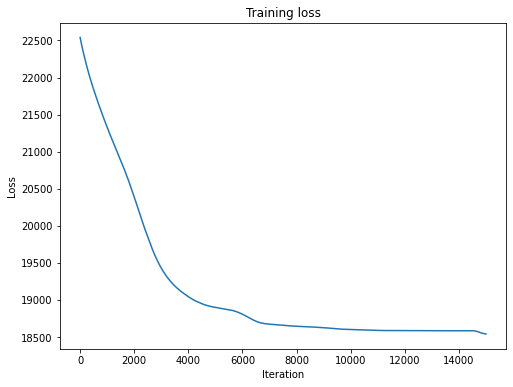

In [174]:
# Plot train loss
plot_train_loss(model)

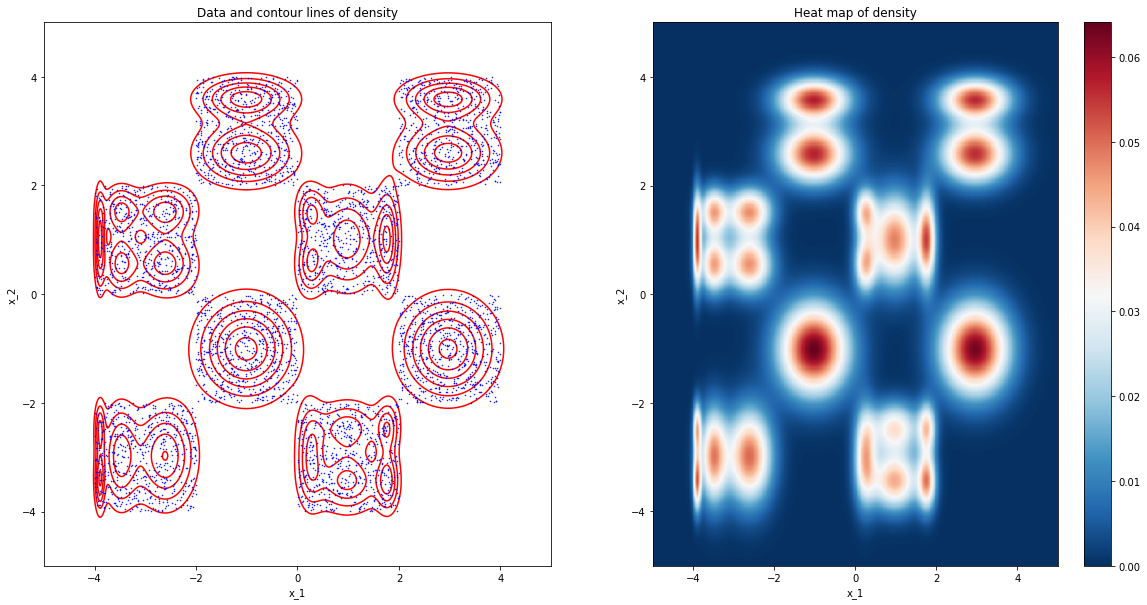

In [175]:
# Plot density
plot_density(model, data)

In [80]:
model.unit_test([(-5, 5), (-5, 5)], opts={'epsabs': 0.01}) # Allow a larger error for faster computation

KeyboardInterrupt: 

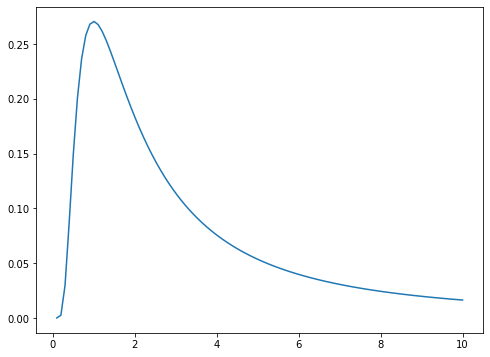

In [105]:
x = np.linspace(0,10, 100)
y = torch.exp(dist.InverseGamma(1,2).log_prob(torch.tensor(x))).numpy()
plt.figure(figsize=(8,6))
plt.plot(x,y)
plt.show()

In [155]:
data.std(dim=0)

tensor([2.2938, 2.3013])

In [162]:
for key, value in pyro.get_param_store().items():
    print(key, torch.exp(value))

k0_weights tensor([1.1251, 1.3199, 1.4634, 1.1162, 1.1206], grad_fn=<ExpBackward>)
params$$$1.weights_unconstrained tensor([[0.0296, 0.4709, 0.0344, 1.2502, 0.5494],
        [0.1930, 0.2058, 0.0968, 0.3612, 0.0846],
        [0.1737, 0.0918, 0.1123, 0.3484, 0.1301],
        [0.0338, 0.7282, 0.2164, 0.0216, 1.2547],
        [0.5890, 0.0262, 0.7476, 0.1105, 0.0992]], grad_fn=<ExpBackward>)
params$$$1.locs_unconstrained tensor([[9.2923e-01, 3.2346e+00, 3.8647e+00, 6.8868e-01, 3.8963e+01],
        [8.0375e-02, 4.1808e-02, 2.6131e-02, 2.6695e-01, 1.6133e-01],
        [2.5302e+00, 5.5765e+00, 8.0037e-02, 1.9929e+01, 1.2859e+01],
        [2.5020e+00, 1.2397e+00, 6.3036e+00, 2.1547e+00, 4.8253e-01],
        [2.6254e-02, 6.3226e-02, 2.1871e+00, 1.9698e+01, 2.3671e-01]],
       grad_fn=<ExpBackward>)
params$$$1.scales_unconstrained tensor([[1.5194, 0.3537, 0.3712, 0.2186, 0.2495],
        [0.3387, 0.4127, 0.2431, 0.3808, 0.1176],
        [0.4808, 0.1827, 0.3332, 0.5423, 0.3472],
        [0.5476, 

In [119]:
2*dist.InverseGamma(1,2).sample((5,3)).std(dim=0)

tensor([ 1.1322,  9.8230, 14.3525])